# ДЗ_11 “Перевод с механизмом внимания”

**Разобраться с моделью перевода (с механизмом внимания) как она устроена, запустить для перевода с русского на английский (при желании можно взять другие пары языков).**

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Загрузим и подготовим данные.


In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2023-11-23 10:43:25--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15824155 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.09M  62.5MB/s    in 0.2s    

2023-11-23 10:43:25 (62.5 MB/s) - ‘rus-eng.zip’ saved [15824155/15824155]



In [3]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 76M
drwxr-xr-x 2 root root 4.0K Nov 23 10:43 .
drwxr-xr-x 1 root root 4.0K Nov 23 10:43 ..
-rw-r--r-- 1 root root 1.5K Jul 30 03:53 _about.txt
-rw-r--r-- 1 root root  76M Jul 30 03:53 rus.txt


In [5]:
path_to_file = "/content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
  w = w.lower().strip()

  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  w = '<start> ' + w + ' <end>'
  return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [10]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Ограничим размер датасета для ускорения обучения.


In [12]:
len(en), len(ru)

(479223, 479223)

In [13]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

**Разделим датасет на train и test.**

In [14]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
312 ----> наша
1101 ----> команда
59 ----> может
374 ----> выиграть
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
155 ----> our
709 ----> team
112 ----> may
140 ----> win
3 ----> .
2 ----> <end>


In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

**Подготовим энкодер.**

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

#инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()

#получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)

    #применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
    #складываем полученные векторы, применяем к сумму тангенс (batch_size, max_length, units)
    #проводим результат через dense слой (batch_size, max_length, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    # получаем вероятностное распределение
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    # умножаем веса внимания на векторы значенй выход (batch_size, max_len, hidden size)
    context_vector = attention_weights * values
    #находим вдоль столбцов (batch_size, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
#создаем слой внимания
attention_layer = BahdanauAttention(10)
#передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


**Подготовим декодер.**

In [23]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # используем слой внимания
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_len, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7386)


## Определим оптимизатор и функцию потерь.

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Подготовим директорию для сохранения сheckpoints.

In [26]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    #получаем выходы encoder
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    #помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
    dec_hidden = enc_hidden

    #формируем вход декодера:
    # берем список длины батч из индексов тега
    # приписываем списку размерность 1
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    #Teacher forcing - выводим target в качестве следующего входа
    for t in range(1, targ.shape[1]):
      #помещаем enc_output, dec_input, dec_hidden в decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # считаем функцию потерь
      loss += loss_function(targ[:, t], predictions)

      # используем teacher forcing (приписываем списку размерность 1)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  #вычисляем градиенты loss по variables
  gradients = tape.gradient(loss, variables)

  #оптимизатор применяет подсчитанные градиенты
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    #делаем шаг обучения и считаем ошибку
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  #сохраняем checkpoint каждые 25 эпох
  if (epoch + 1) % 25 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6814
Epoch 1 Batch 100 Loss 2.0746
Epoch 1 Batch 200 Loss 1.8939
Epoch 1 Batch 300 Loss 1.7794
Epoch 1 Batch 400 Loss 1.6425
Epoch 1 Batch 500 Loss 1.4609
Epoch 1 Batch 600 Loss 1.4414
Epoch 1 Batch 700 Loss 1.3560
Epoch 1 Batch 800 Loss 1.2123
Epoch 1 Batch 900 Loss 1.1352
Epoch 1 Batch 1000 Loss 1.0803
Epoch 1 Batch 1100 Loss 1.0256
Epoch 1 Batch 1200 Loss 0.8953
Epoch 1 Loss 1.4532
Time taken for 1 epoch 112.99495005607605 sec

Epoch 2 Batch 0 Loss 0.7436
Epoch 2 Batch 100 Loss 0.7745
Epoch 2 Batch 200 Loss 0.6272
Epoch 2 Batch 300 Loss 0.7873
Epoch 2 Batch 400 Loss 0.6609
Epoch 2 Batch 500 Loss 0.6156
Epoch 2 Batch 600 Loss 0.6316
Epoch 2 Batch 700 Loss 0.5422
Epoch 2 Batch 800 Loss 0.6407
Epoch 2 Batch 900 Loss 0.5634
Epoch 2 Batch 1000 Loss 0.4617
Epoch 2 Batch 1100 Loss 0.6327
Epoch 2 Batch 1200 Loss 0.4471
Epoch 2 Loss 0.6245
Time taken for 1 epoch 95.9978837966919 sec

Epoch 3 Batch 0 Loss 0.2805
Epoch 3 Batch 100 Loss 0.3786
Epoch 3 Batch 200 Loss 0.307

In [29]:
def evaluate(sentence):
  #строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  #выполняем препроцессинг предложений
  sentence = preprocess_sentence(sentence)

  #разбиваем предложение по пробелам и составляем список индексов каждого слова
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  #дополняем inputs нулями справа до максимальной длины входного текста
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  #преобразуем inputs в тензор
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  #инициализируем входной hidden из нулей размера (1, units)
  hidden = [tf.zeros((1, units))]
  #подаем inputs и hidden в encoder
  enc_out, enc_hidden = encoder(inputs, hidden)

  #инициализируем входной hidden декодера -- выходной хидден энкодера
  dec_hidden = enc_hidden
  #вход декодера -- список [индекс start] размера(1,1)
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    #получаем выход декодера
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    #сохраняем веса внимания, чтобы позже визуализировать
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    #заканчиваем на токене end
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    #предсказанный predicted ID подаем обратно в декодер (размер (1,1))
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

**Напишем функцию для визуализации весов внимания.**

In [30]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [31]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Загрузим последний чекпойнт.

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here soon . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


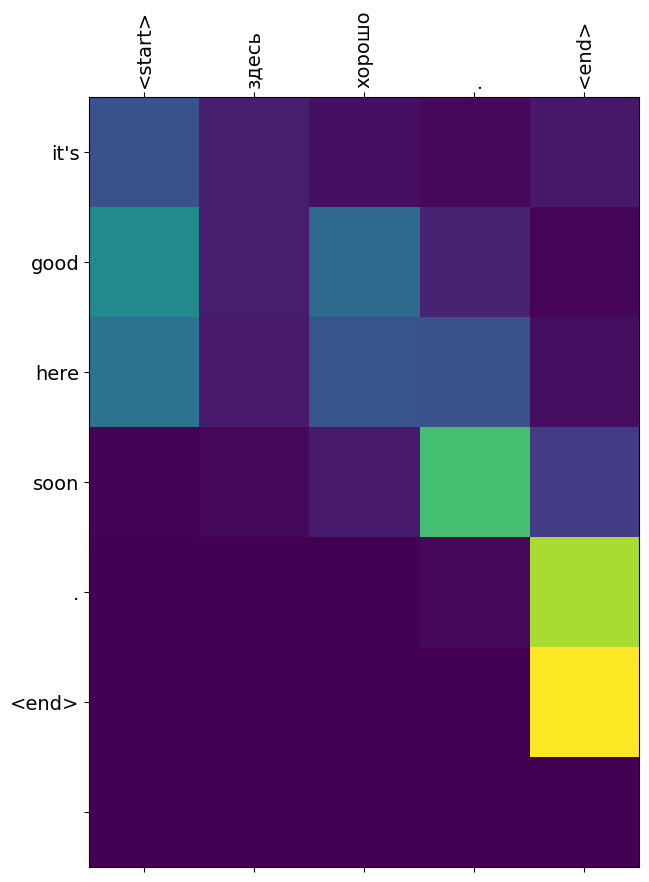

In [33]:
translate('Здесь хорошо.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


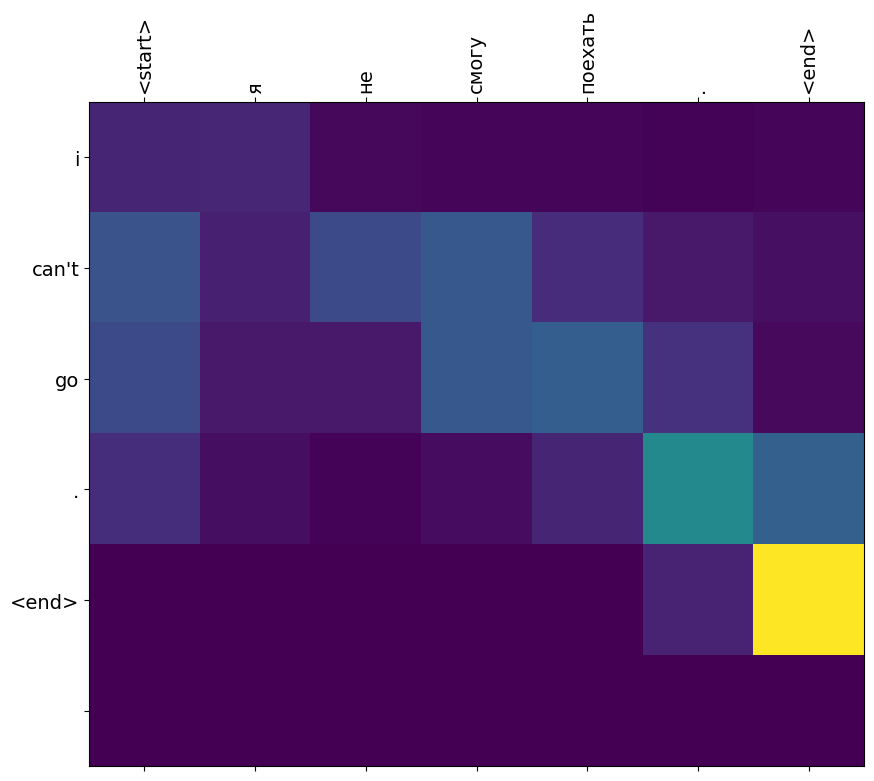

In [34]:
translate('Я не смогу поехать.')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


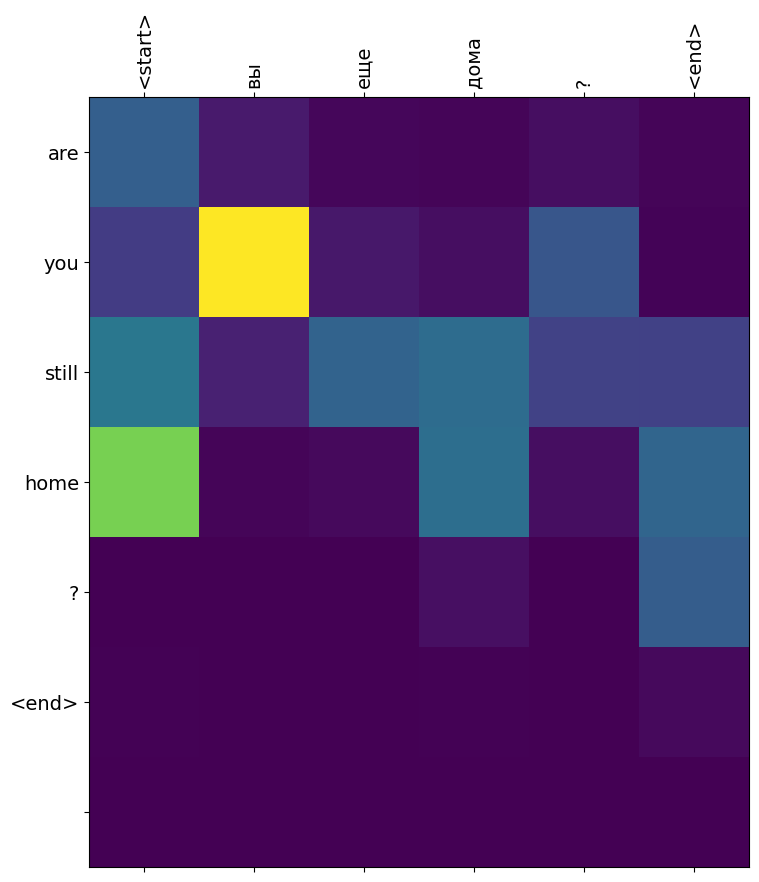

In [35]:
translate(u'Вы еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you all home yet ? <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


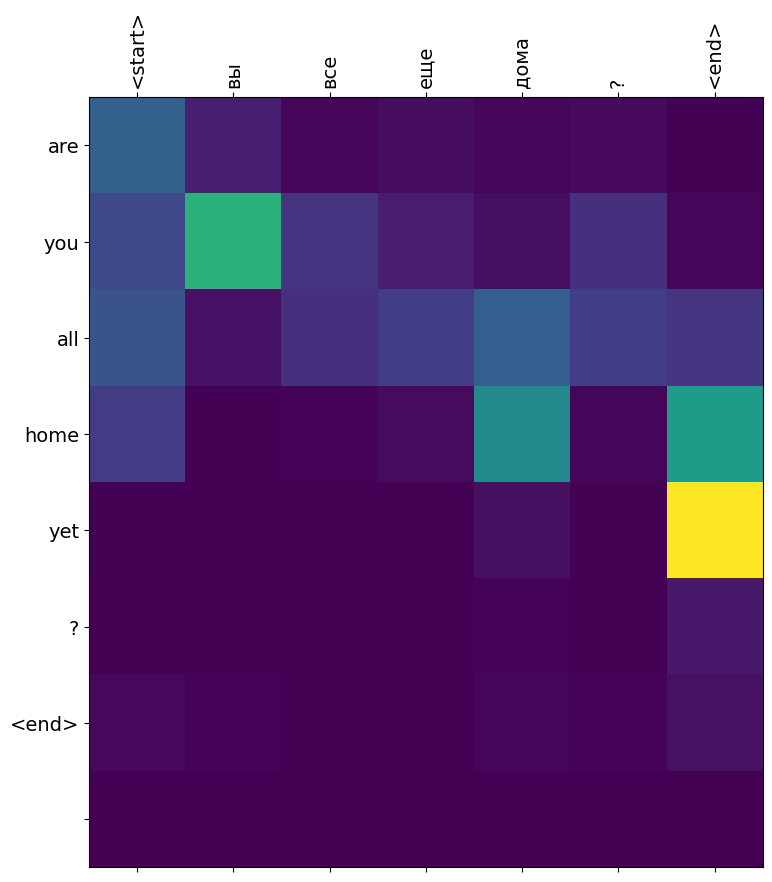

In [36]:
translate(u'Вы все еще дома?')

Input: <start> вы что , все еще дома ? <end>
Predicted translation: aren't you all home ? <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


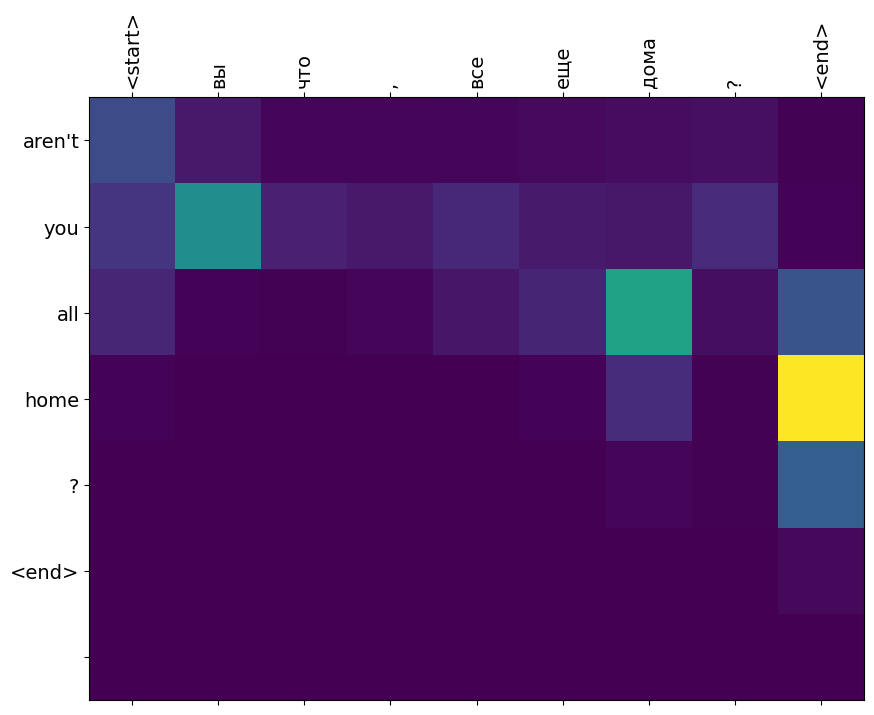

In [37]:
translate(u'Вы что, все еще дома?')

Input: <start> фильм хороший ! <end>
Predicted translation: the movie is good . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


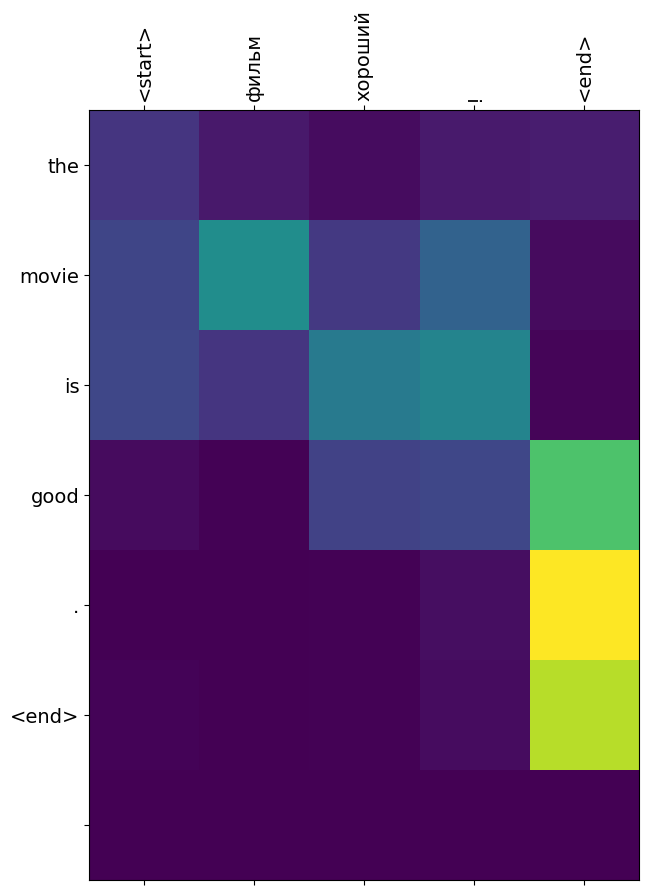

In [38]:
translate(u'Фильм хороший!')

Input: <start> фильм не совсем хороший ! <end>
Predicted translation: the pretty good at all good . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


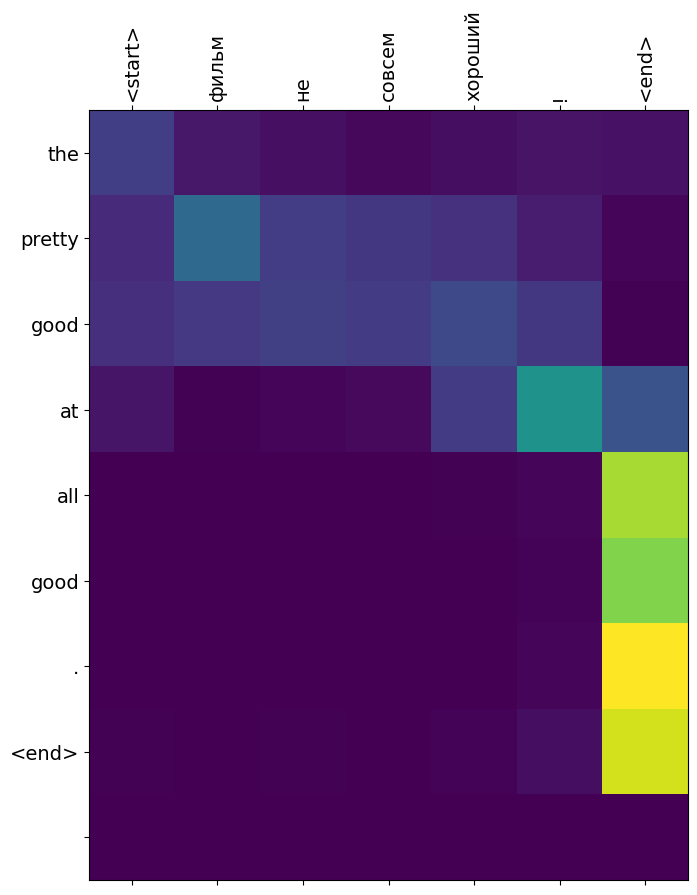

In [39]:
translate(u'Фильм не совсем хороший!')

Input: <start> фильм совсем не хороший ! <end>
Predicted translation: it's pretty good at all good ! <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


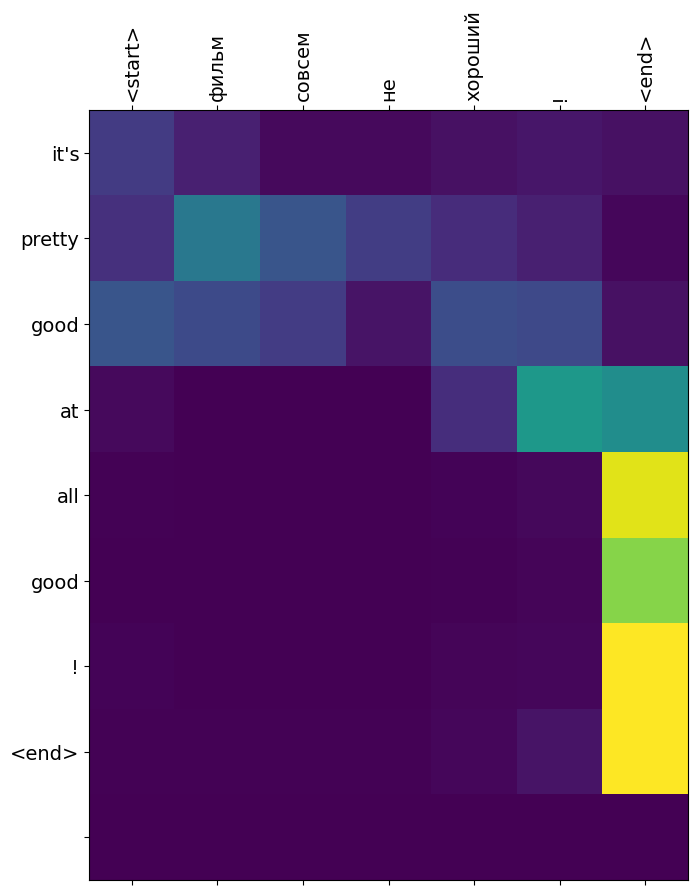

In [40]:
translate(u'Фильм совсем не хороший!')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do this . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


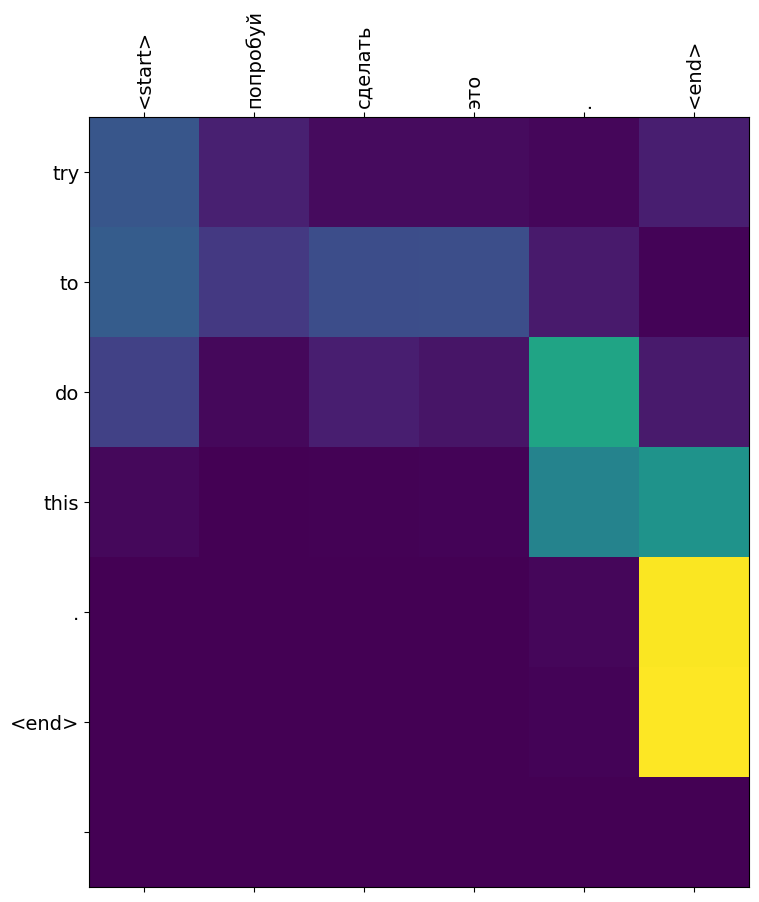

In [41]:
translate(u'Попробуй сделать это.')

Input: <start> надо в магазине купить воду . <end>
Predicted translation: we have a new water . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


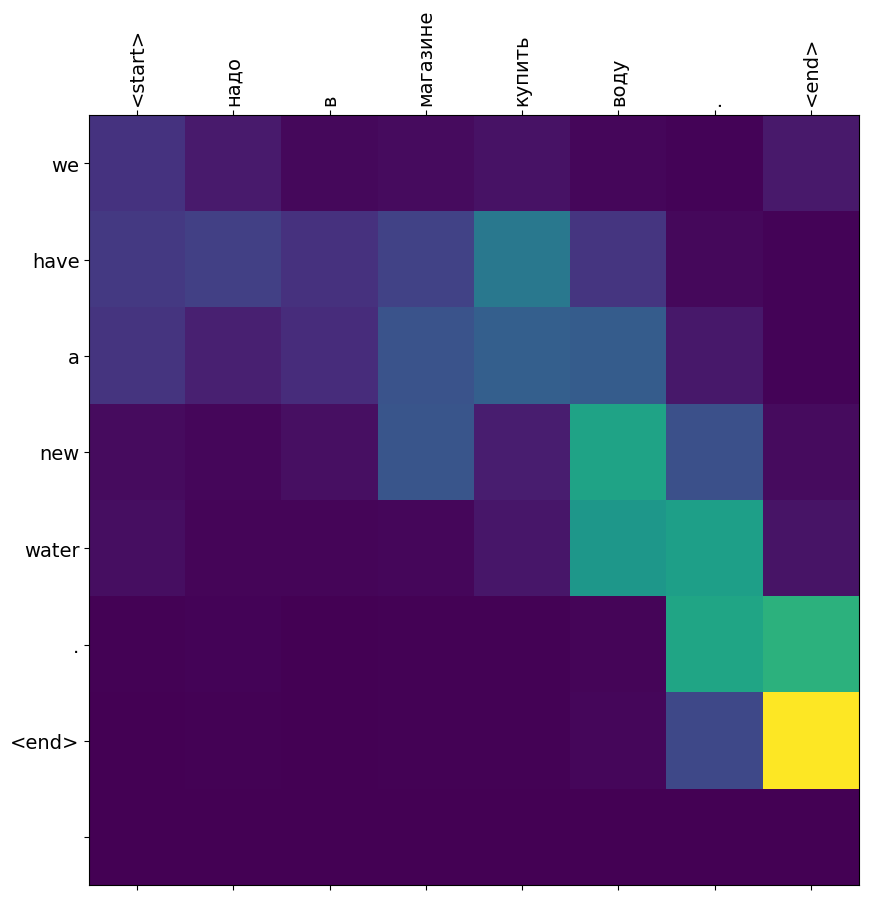

In [42]:
translate(u'Надо в магазине купить воду.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


<ipython-input-30-7689413cfce7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-30-7689413cfce7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


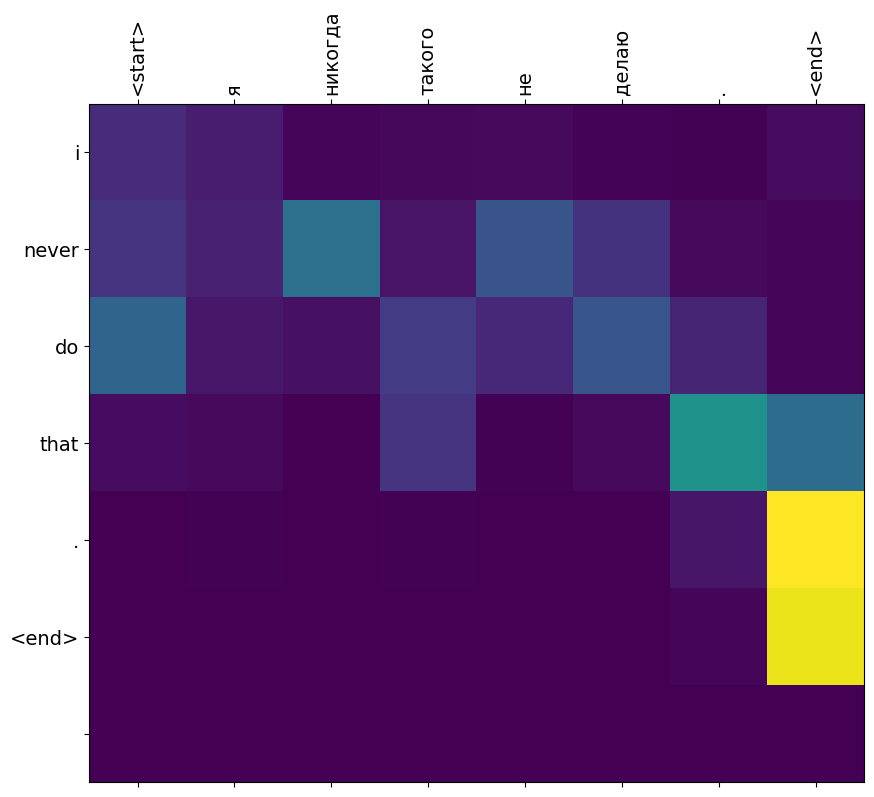

In [43]:
translate(u'Я никогда такого не делаю.')

### ВЫВОД: модель работает, с короткими и однозначными выражениями справляется хорошо. Но с переводом длинных выражений, а так же с выражениями, содержащими нюансы, модель испытывает затруднения. На мой взгляд работает лучше, чем модель без "внимания", но не существенно.